| โมเดล                                | ใช้ตอนไหน                                | จุดเด่น                                       | จุดด้อย                                            |
| ------------------------------------ | ---------------------------------------- | --------------------------------------------- | -------------------------------------------------- |
| 🪵 **Random Forest (RF)**            | ตอนเริ่มต้น (Baseline / Feature Ranking) | เข้าใจง่าย, คำนวณ feature importance ได้ตรง ๆ | จับ pattern temporal ไม่เก่ง (ไม่รู้เรื่อง “เวลา”) |
| ⚡ **XGBoost / LightGBM**             | ตอน tuning feature หรือตอนทำ ensemble    | แรง, จับ nonlinear relation ดี                | ยังไม่รู้เรื่อง “sequence”                         |
| 🧠 **LSTM / CNN-LSTM / Transformer** | ตอนเข้า phase deep learning              | จับ pattern ตามเวลา, ความสัมพันธ์ระยะยาว      | ต้องการข้อมูลมาก, interpret ยาก                    |


Workflow ที่ดีที่สุด (สำหรับ Quant Deep Model)
```bash
   ┌──────────────────────┐
   │ Raw Data (OHLCV etc.)│
   └────────────┬─────────┘
                ↓
       Feature Engineering
                ↓
   ┌────────────┬────────────┐
   │   XGBoost   │  LSTM/CNN │
   │  (Feature   │ (Deep Seq │
   │  Selector)  │  Learner) │
   └──────┬──────┴──────┬────┘
          ↓             ↓
      Selected       Prediction
     Features           ↓
          └──────→ XGBoost (Meta Decision)
```

In [ ]:
!pip install -q mplfinance
!pip install -q ta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/IS_Safem0de

 Ensemble_LSTM_and_Candlestick_for_Trading_System.pdf
 EURUSD_H4.csv
'[Prelim]_67130503-Ensemble LSTM and Candlestick for Trading System.pdf'
'Prelim - 67130503.pdf'


In [ ]:
data_path = '/content/drive/MyDrive/IS_Safem0de/EURUSD_H4.csv'

In [ ]:
df = pd.read_csv(data_path)
df.tail()

,2009-10-05 20:00,1.46469,1.46609,1.46436,1.46558,2247
25842,2025-10-15 08:00,1.16355,1.16453,1.16195,1.16199,16243
25843,2025-10-15 12:00,1.16201,1.16472,1.16103,1.16369,25939
25844,2025-10-15 16:00,1.16371,1.16448,1.16269,1.16441,14745
25845,2025-10-15 20:00,1.16442,1.16519,1.16418,1.16456,5554
25846,2025-10-16 00:00,1.16455,1.16754,1.16425,1.16659,14450


In [ ]:
# ตรวจชื่อคอลัมน์
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

# แปลง datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# ตั้ง index เป็นเวลา (สะดวกกับการ plot)
df.set_index('datetime', inplace=True)

df.head()

,open,high,low,close,volume
datetime,,,,,
2009-10-06 00:00:00,1.46563,1.47178,1.46541,1.47035,10300
2009-10-06 04:00:00,1.47051,1.47486,1.46951,1.47169,12566
2009-10-06 08:00:00,1.47176,1.47458,1.47068,1.47264,18816
2009-10-06 12:00:00,1.47270,1.47612,1.46951,1.47416,15619
2009-10-06 16:00:00,1.47409,1.47537,1.47023,1.47160,13948


เตรียมข้อมูล (Feature Engineering)

In [ ]:
import numpy as np
def fractal_dimension(series, window=50):
    L = (series.diff().abs().rolling(window).sum())
    d = np.log(L / window) / np.log(2/window)
    return d

In [ ]:
# 2️⃣ เพิ่ม Feature
import ta

df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['stoch_rsi'] = ta.momentum.StochRSIIndicator(df['close'], window=14, smooth1=3, smooth2=3).stochrsi()
# For stoch_rsi plot
df['stoch_rsi_plot'] = df['stoch_rsi'] * 100

df['ema_fast'] = ta.trend.EMAIndicator(df['close'], window=10).ema_indicator()
df['ema_slow'] = ta.trend.EMAIndicator(df['close'], window=50).ema_indicator()
df['macd'] = ta.trend.MACD(df['close']).macd()
df['atr'] = ta.volatility.AverageTrueRange(
    high=df['high'], low=df['low'], close=df['close'], window=14
).average_true_range()
df['willr'] = ta.momentum.WilliamsRIndicator(df['high'], df['low'], df['close'], lbp=14).williams_r()
df['cci'] = ta.trend.CCIIndicator(df['high'], df['low'], df['close'], window=20).cci()
# Ease of Movement (EoM)
df['eom'] = ta.volume.EaseOfMovementIndicator(
    high=df['high'], low=df['low'], volume=df['volume'], window=14
).ease_of_movement()
# Bollinger Band Width (BBW)
df['bb_width'] = ta.volatility.BollingerBands(df['close'], window=20).bollinger_wband()
# Fractal Dimension Index (FDI)
df['fdi'] = fractal_dimension(df['close'])

# MFI (Money Flow Index) — RSI เวอร์ชันมี Volume
df['mfi'] = ta.volume.MFIIndicator(
    high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=14
).money_flow_index()
# OBV (On-Balance Volume)
df['obv'] = ta.volume.OnBalanceVolumeIndicator(
    close=df['close'], volume=df['volume']
).on_balance_volume()
# VWAP (Volume Weighted Average Price)
df['vwap'] = ta.volume.VolumeWeightedAveragePrice(
    high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=14
).volume_weighted_average_price()
# ROC (Rate of Change) — Momentum ที่ไม่ lag
df['roc'] = ta.momentum.ROCIndicator(df['close'], window=10).roc()

# ลบค่า NaN ที่เกิดจากการคำนวณ Indicator
df.dropna(inplace=True)

# ✅ ตอนนี้ df พร้อมแล้วสำหรับการ Normalize และสร้าง X, y
print(df.head())

                        open     high      low    close  volume        rsi  \
datetime                                                                     
2009-10-16 04:00:00  1.49318  1.49395  1.48887  1.49033   12455  55.727888   
2009-10-16 08:00:00  1.49038  1.49257  1.48663  1.48846   18481  52.715075   
2009-10-16 12:00:00  1.48847  1.49113  1.48463  1.48866   16028  53.007692   
2009-10-16 16:00:00  1.48855  1.49069  1.48705  1.48916   14263  53.777801   
2009-10-16 20:00:00  1.48925  1.49055  1.48871  1.49032    3753  55.595913   

                     stoch_rsi  stoch_rsi_plot  ema_fast  ema_slow  ...  \
datetime                                                            ...   
2009-10-16 04:00:00   0.000000        0.000000  1.491612  1.482057  ...   
2009-10-16 08:00:00   0.000000        0.000000  1.491039  1.482308  ...   
2009-10-16 12:00:00   0.015189        1.518858  1.490606  1.482558  ...   
2009-10-16 16:00:00   0.055162        5.516184  1.490343  1.482816  ...   
200

In [ ]:
df['stoch_rsi'].describe()

,stoch_rsi
count,25797.000000
mean,0.503116
std,0.363726
min,0.000000
25%,0.147010
50%,0.508040
75%,0.857712
max,1.000000


Plot indicator หลักเทียบราคา

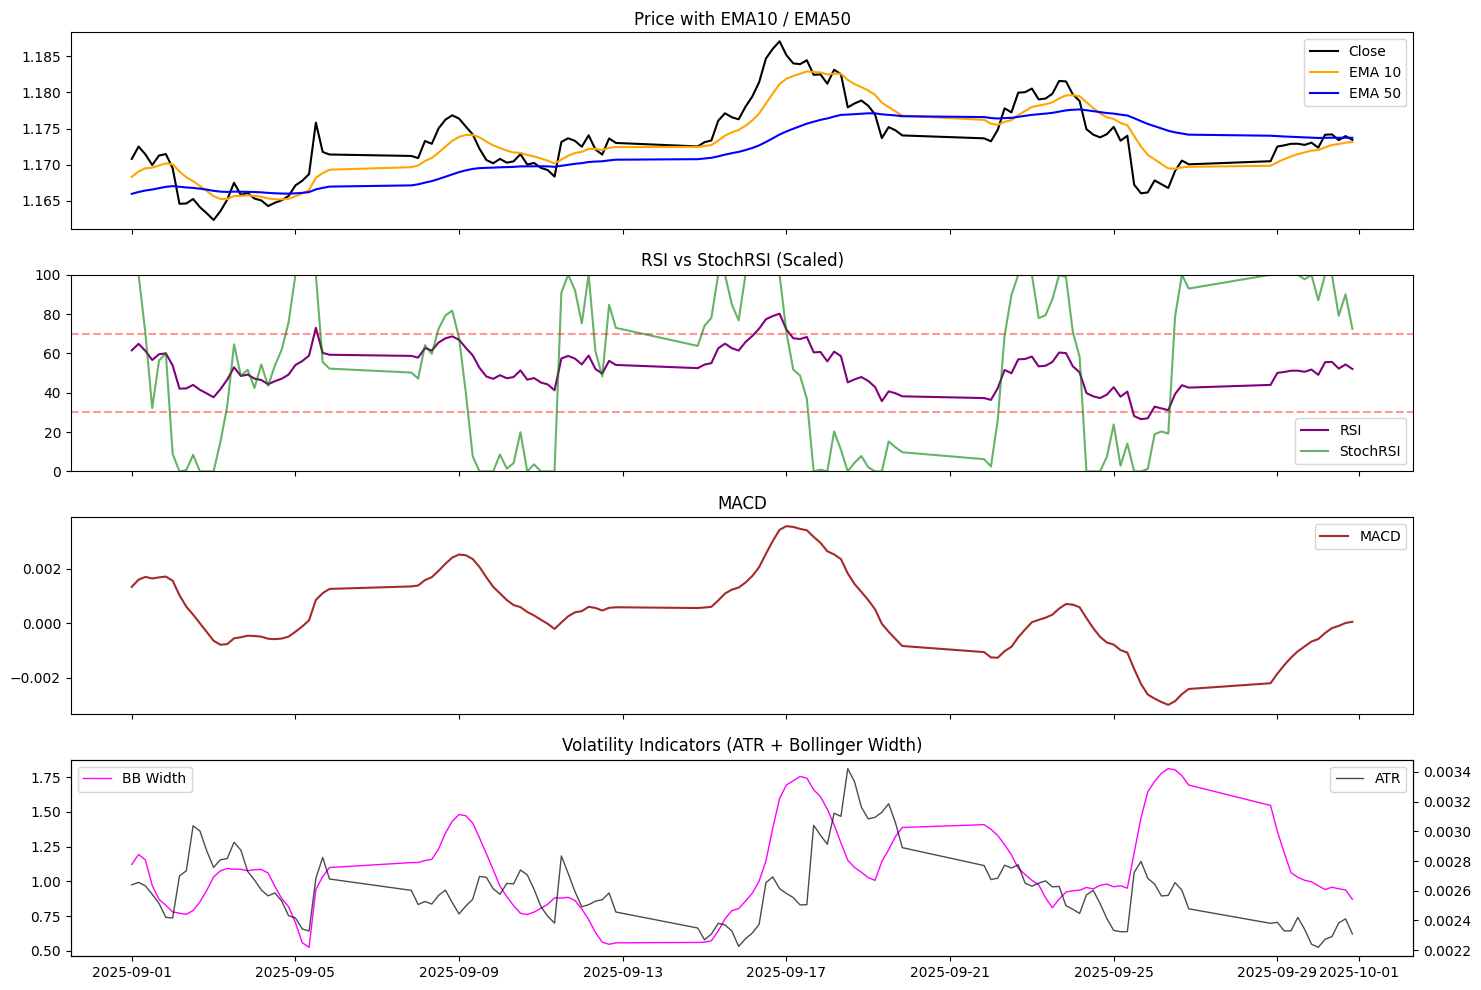

In [ ]:
df_focus = df.loc['2025-09']  # เฉพาะเดือนกันยายน 2025

fig, axs = plt.subplots(4, 1, figsize=(15,10), sharex=True)

# === Price with EMA ===
axs[0].plot(df_focus.index, df_focus['close'], color='black', label='Close')
axs[0].plot(df_focus.index, df_focus['ema_fast'], color='orange', label='EMA 10')
axs[0].plot(df_focus.index, df_focus['ema_slow'], color='blue', label='EMA 50')
axs[0].set_title('Price with EMA10 / EMA50')
axs[0].legend()

# === RSI vs StochRSI ===
axs[1].plot(df_focus.index, df_focus['rsi'], color='purple', label='RSI')
axs[1].plot(df_focus.index, df_focus['stoch_rsi_plot'], color='green', label='StochRSI', alpha=0.6)
axs[1].axhline(70, color='red', linestyle='--', alpha=0.4)
axs[1].axhline(30, color='red', linestyle='--', alpha=0.4)
axs[1].set_ylim(0, 100)
axs[1].legend()
axs[1].set_title('RSI vs StochRSI (Scaled)')

# === MACD ===
axs[2].plot(df_focus.index, df_focus['macd'], color='brown', label='MACD')
axs[2].legend()
axs[2].set_title('MACD')

# === Volatility (BB Width + ATR) ===
ax_vol = axs[3]
ax_atr = ax_vol.twinx()

ax_vol.plot(df_focus.index, df_focus['bb_width'], color='magenta', label='BB Width', linewidth=1)
ax_atr.plot(df_focus.index, df_focus['atr'], color='black', label='ATR', linewidth=1, alpha=0.7)

ax_vol.set_title('Volatility Indicators (ATR + Bollinger Width)')
ax_vol.legend(loc='upper left')
ax_atr.legend(loc='upper right')

plt.tight_layout()
plt.show()

Plot indicator ที่เกี่ยวกับ Volume & Flow

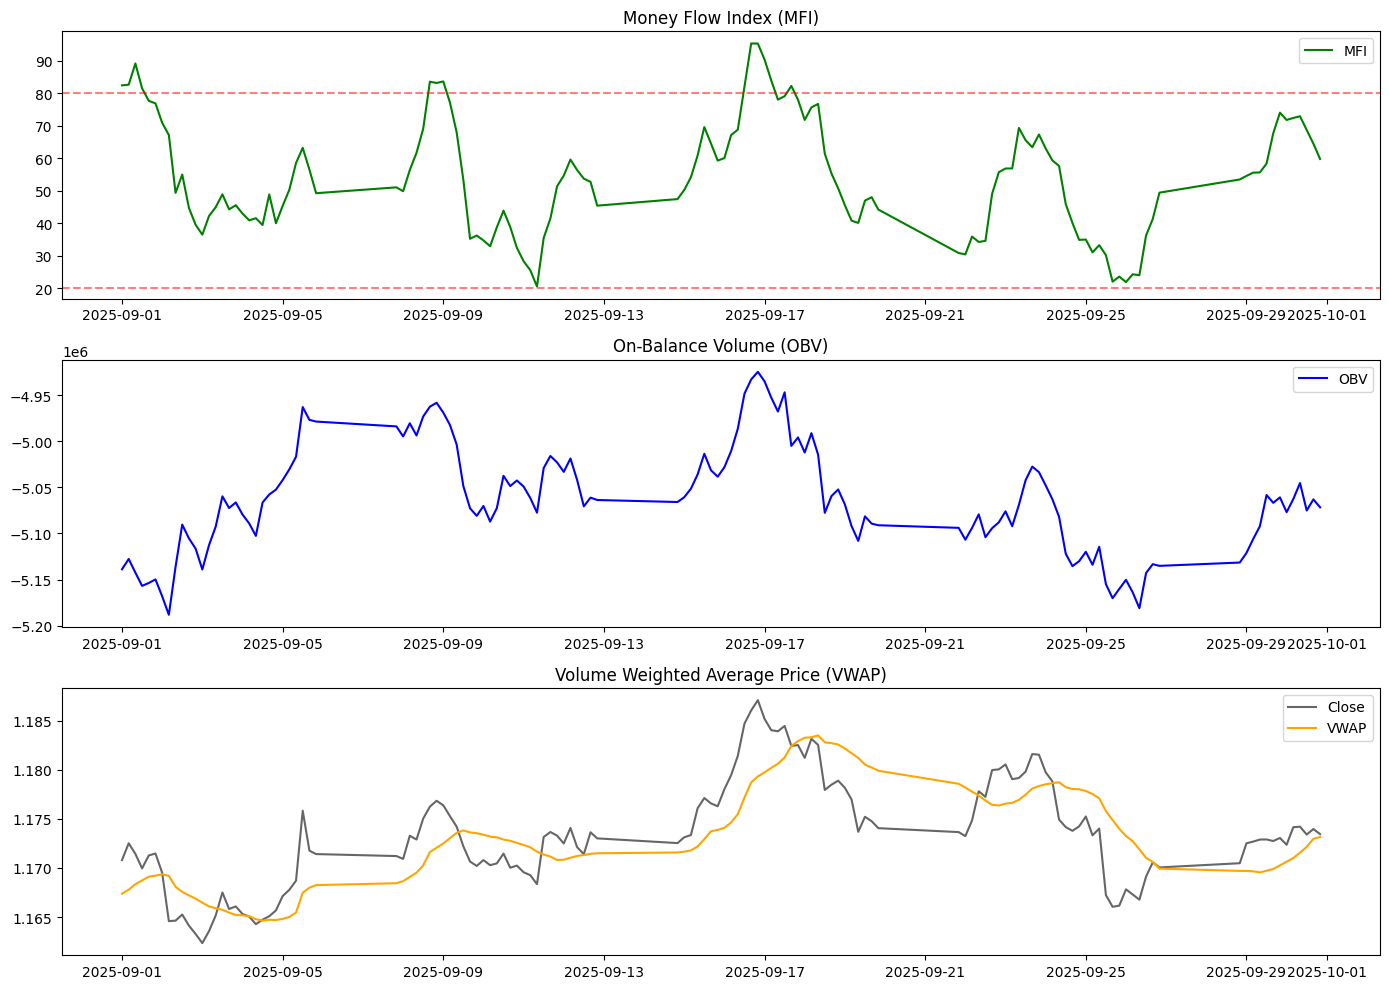

In [ ]:
plt.figure(figsize=(14, 10))

# ---- MFI & CMF ----
plt.subplot(3, 1, 1)
plt.plot(df_focus.index, df_focus['mfi'], label='MFI', color='green')
plt.axhline(80, color='red', linestyle='--', alpha=0.5)
plt.axhline(20, color='red', linestyle='--', alpha=0.5)
plt.title('Money Flow Index (MFI)')
plt.legend()

# ---- OBV ----
plt.subplot(3, 1, 2)
plt.plot(df_focus.index, df_focus['obv'], label='OBV', color='blue')
plt.title('On-Balance Volume (OBV)')
plt.legend()

# ---- VWAP ----
plt.subplot(3, 1, 3)
plt.plot(df_focus.index, df_focus['close'], label='Close', color='black', alpha=0.6)
plt.plot(df_focus.index, df_focus['vwap'], label='VWAP', color='orange')
plt.title('Volume Weighted Average Price (VWAP)')
plt.legend()

plt.tight_layout()
plt.show()

Heatmap แสดงความสัมพันธ์ของทุก Indicator

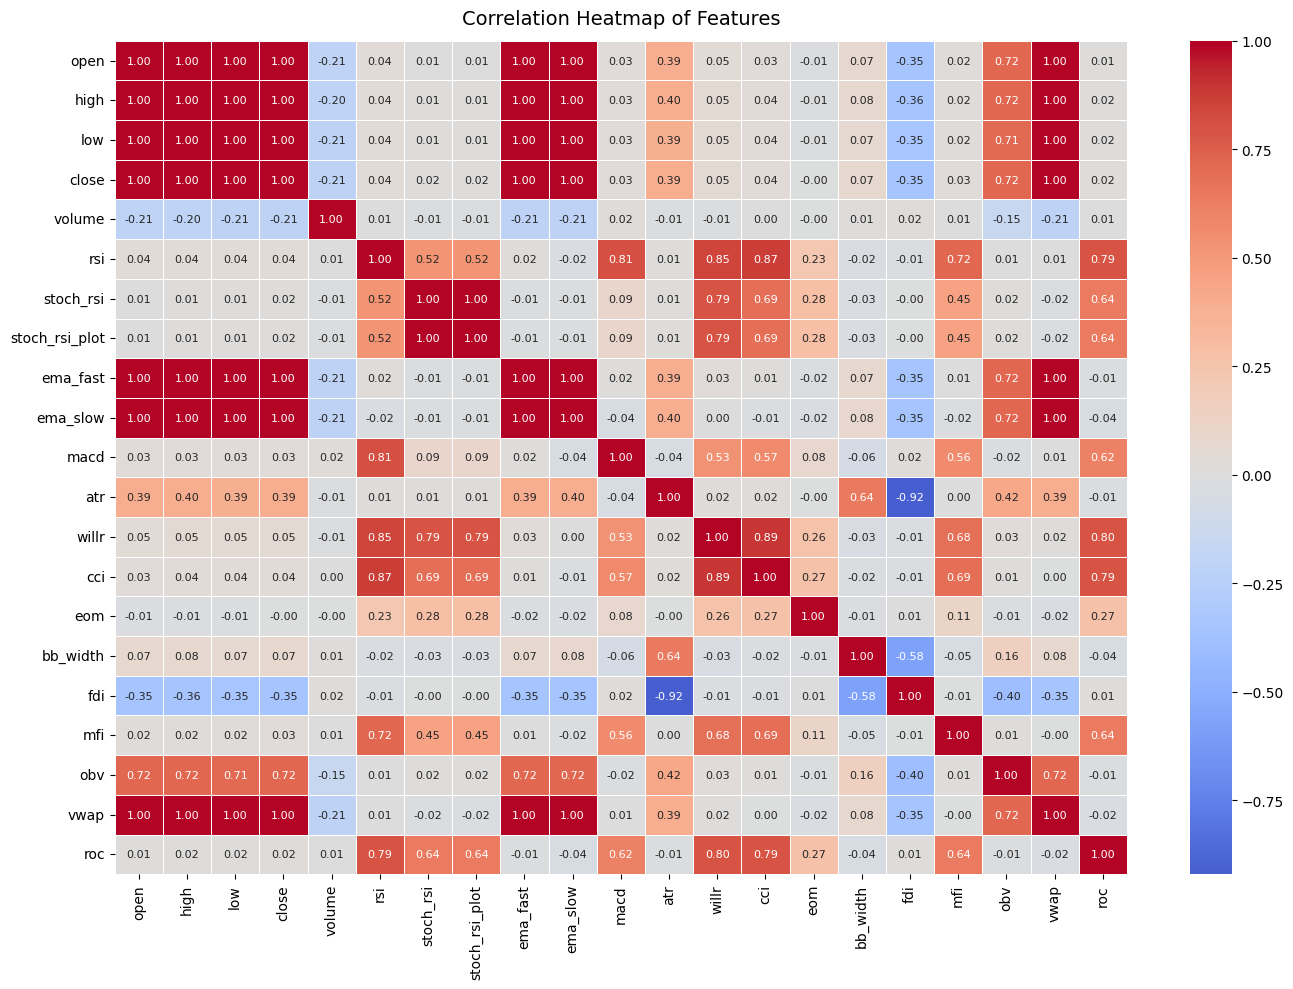

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(
    df.corr(),
    cmap='coolwarm',       # โทนสีแดง-น้ำเงิน
    center=0,              # ศูนย์กลางสี = 0 (ไม่มีความสัมพันธ์)
    annot=True,            # ✅ แสดงค่าตัวเลข
    fmt=".2f",             # แสดงทศนิยม 2 ตำแหน่ง
    annot_kws={"size": 8}, # ขนาดตัวหนังสือในช่อง
    linewidths=0.5          # เส้นแบ่งช่องบาง ๆ ให้อ่านง่ายขึ้น
)
plt.title('Correlation Heatmap of Features', fontsize=14, pad=12)
plt.tight_layout()
plt.show()

###🔹 1. ลบคอลัมน์ที่มีค่าสหสัมพันธ์สูงกันเอง (> corr_thresh)

เป้าหมาย: ลด multicollinearity (feature ซ้ำซ้อนกันมากเกินไป)

💡 ตัวอย่าง

สมมติในชุดข้อมูลคุณมี
```bash
ema_fast (10-day) ≈ ema_slow (50-day)
macd ≈ ema_fast - ema_slow
```

ค่า correlation (corr) ระหว่าง ema_fast กับ macd อาจสูงถึง 0.95
แปลว่า **สองตัวนี้ให้ข้อมูลซ้ำกันเกินไป**
| feature  | feature | corr             |
| -------- | ------- | ---------------- |
| ema_fast | macd    | 0.95 ✅ ตัดได้    |
| high     | low     | 0.8 ❌ เก็บไว้ได้ |

🔧 ทำไมต้องลบ

* โมเดล deep learning จะ “งง” ว่าควรเชื่อ feature ไหน (เกิด overfit)
* ค่า weight ของ layer แรกอาจ bias ไปทาง feature ที่ซ้ำ
* การตีความ feature importance จะบิดเบือน

🧠 วิธีเลือกตัวที่เก็บ

โดยทั่วไปจะ “เก็บตัวแรกไว้ ลบตัวหลัง”
หรือใช้ “ตัวที่เข้าใจง่ายกว่า” เช่นเก็บ `macd` ลบ `ema_fast/slow`

---
###🔹 2. ลบคอลัมน์ที่สัมพันธ์กับ target น้อยกว่า target_corr_thresh

เป้าหมาย: ตัด feature ที่ "ไม่ช่วยทำนายราคา" ออกไปก่อน train

💡 ตัวอย่าง
เราดู correlation ของทุก feature กับ `close`

| feature  | corr(close)           |
| -------- | --------------------- |
| rsi      | 0.45 ✅ มีความสัมพันธ์ |
| ema_fast | 0.38 ✅                |
| bb_width | 0.02 ❌                |
| obv      | 0.07 ❌                |

ถ้าเราตั้ง `target_corr_thresh = 0.05`
→ feature ที่สัมพันธ์ต่ำกว่า 0.05 จะถูกตัดทิ้ง เช่น `bb_width`, `obv`

🔧 ทำไมต้องลบ

* ช่วยลดจำนวน feature โดยไม่ลดคุณภาพการทำนาย
* ลดการ overfit เพราะ feature ที่ไม่เกี่ยวข้องจะสร้าง noise
* ทำให้ training เร็วขึ้น และค่าพารามิเตอร์น้อยลง

⚠️ หมายเหตุ

ไม่ต้องตั้ง threshold สูง (0.05-0.1 พอ)
เพราะบาง feature (เช่น ROC, RSI) มีความสัมพันธ์เชิง ไม่เชิงเส้น
แต่ deep learning สามารถจับ pattern แบบ nonlinear ได้

---
###🔹 3. ลบคอลัมน์ที่มี NaN เกิน 5%

เป้าหมาย: กันโมเดลไม่ให้โดน NaN input (ซึ่งเทรนไม่ได้)

💡 ตัวอย่าง

บาง indicator ต้องใช้ rolling window เช่น:

* EMA 50 → ต้องใช้ข้อมูล 50 แท่งแรก → 49 แท่งแรกจะเป็น NaN
* ATR 14 → ต้องใช้ high/low/close ครบ → ถ้า missing 1 ตัวก็ NaN
```bash
na_ratio = df.isna().mean()
```

ถ้าค่าเฉลี่ยของ NaN ใน column ใดมากกว่า 0.05 (5%) → ตัดออกเลย

🔧 ทำไมต้องลบ

* LSTM/CNN จะ error ถ้า input มี NaN
* การ fill ด้วย 0 หรือ mean อาจบิด pattern ของราคา
* ถ้า missing เยอะ → แปลว่า indicator นั้นใช้ไม่ได้กับ timeframe นี้
---

###🔍 ภาพรวม: ทั้งสามข้อช่วยอะไร

| ขั้นตอน                        | เป้าหมาย              | ผลที่ได้                        |
| ------------------------------ | --------------------- | ------------------------------- |
| **(1)** ลบ feature ซ้ำกัน      | ลด multicollinearity  | โมเดลเรียนรู้ได้เสถียรขึ้น      |
| **(2)** ลบ feature ไม่สัมพันธ์ | ลด noise / overfit    | โมเดลโฟกัสที่ feature สำคัญจริง |
| **(3)** ลบ NaN เยอะ            | ป้องกัน error ตอนเทรน | ข้อมูลสะอาดและสมบูรณ์           |


In [ ]:
import numpy as np
import pandas as pd

def select_features(df, target_col='close', corr_thresh=0.9, target_corr_thresh=0.05):
    """
    ตัด feature ที่ไม่จำเป็นออกโดยอัตโนมัติ
    1. ลบคอลัมน์ที่มีค่าสัมประสิทธิ์สหสัมพันธ์สูงกันเอง (> corr_thresh)
    2. ลบคอลัมน์ที่สัมพันธ์กับ target น้อยกว่า target_corr_thresh
    3. ลบคอลัมน์ที่มี NaN เกิน 5%
    """
    df = df.copy()

    # ✅ 1. ลบ column ที่มี missing เยอะเกิน
    na_ratio = df.isna().mean()
    drop_na_cols = na_ratio[na_ratio > 0.05].index.tolist()
    df.drop(columns=drop_na_cols, inplace=True)
    print(f"🧹 Dropped NaN-heavy columns: {drop_na_cols}")

    # ✅ 2. ความสัมพันธ์กับ target
    corr_with_target = df.corr()[target_col].abs().sort_values(ascending=False)
    keep_cols = corr_with_target[corr_with_target > target_corr_thresh].index.tolist()
    df = df[keep_cols]
    print(f"🎯 Kept {len(keep_cols)} features correlated with {target_col}")

    # ✅ 3. ลบคอลัมน์ที่ซ้ำกันมาก (correlation สูง)
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_thresh)]
    df.drop(columns=high_corr_cols, inplace=True, errors='ignore')
    print(f"⚙️ Removed highly correlated features: {high_corr_cols}")

    print(f"✅ Final features ({len(df.columns)}): {list(df.columns)}")
    return df

In [ ]:
filtered_df = select_features(df, target_col='close', corr_thresh=0.9, target_corr_thresh=0.05)

# เตรียมสำหรับเทรน
feature_cols = [col for col in filtered_df.columns if col != 'close']
X = filtered_df[feature_cols]
y = filtered_df['close']

print("\n")
print(filtered_df.head())

🧹 Dropped NaN-heavy columns: []
🎯 Kept 13 features correlated with close
⚙️ Removed highly correlated features: ['low', 'high', 'open', 'ema_fast', 'vwap', 'ema_slow', 'fdi']
✅ Final features (6): ['close', 'obv', 'atr', 'volume', 'bb_width', 'willr']


                       close    obv       atr  volume  bb_width      willr
datetime                                                                  
2009-10-16 04:00:00  1.49033  50592  0.005160   12455  1.443220 -49.696049
2009-10-16 08:00:00  1.48846  32111  0.005216   18481  1.253704 -65.960784
2009-10-16 12:00:00  1.48866  48139  0.005307   16028  0.987566 -64.392157
2009-10-16 16:00:00  1.48916  62402  0.005188   14263  0.959010 -60.470588
2009-10-16 20:00:00  1.49032  66155  0.004949    3753  0.875653 -51.372549


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1️⃣ แยก train/test ตามเวลา (ไม่ shuffle - Prevent Data Leakage)
train_size = int(len(filtered_df) * 0.8)
train_df = filtered_df.iloc[:train_size]
test_df = filtered_df.iloc[train_size:]

# ✅ เพิ่ม scaler สำหรับราคาจริง (ใช้เฉพาะตอน inverse)
price_cols = ['open', 'high', 'low', 'close', 'volume']
scaler_price = MinMaxScaler()
scaler_price.fit(df[price_cols])   # fit จากราคาจริงต้นฉบับ (ไม่ผ่าน feature selection)

# 2️⃣ scaler สำหรับเทรนโมเดล (ใช้ features หลัง select แล้ว)
scaler = MinMaxScaler()
scaler.fit(train_df)  # ✅ fit เฉพาะ feature ที่เหลือใน filtered_df

# 3️⃣ แปลงข้อมูลทั้งหมดตาม feature ที่เหลือจริง
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

# 4️⃣ แปลงกลับเป็น DataFrame (ชื่อคอลัมน์ไม่หาย)
train_scaled = pd.DataFrame(train_scaled, columns=filtered_df.columns, index=train_df.index)
test_scaled = pd.DataFrame(test_scaled, columns=filtered_df.columns, index=test_df.index)

print("✅ Scaling complete. Use 'scaler' for training, and 'scaler_price' for plotting real prices.")

✅ Scaling complete. Use 'scaler' for training, and 'scaler_price' for plotting real prices.


สร้าง Time-Series Sequence สำหรับ LSTM

In [ ]:
def create_sequences(data, seq_len, target_idx):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

In [ ]:
SEQ_LEN = 50

target_idx = filtered_df.columns.get_loc('close')
X_train, y_train = create_sequences(train_scaled.values, SEQ_LEN, target_idx)
X_test, y_test = create_sequences(test_scaled.values, SEQ_LEN, target_idx)

print(X_train.shape, X_test.shape)

(20587, 50, 6) (5110, 50, 6)


Define Models

In [ ]:
# -----------------------------
# LSTM 64
# -----------------------------
def build_lstm_64():
    model = Sequential([
        Input(shape=(SEQ_LEN, X_train.shape[2])),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# -----------------------------
# LSTM 128
# -----------------------------
# def build_lstm_128():
#     model = Sequential([
#         Input(shape=(SEQ_LEN, X_train.shape[2])),
#         LSTM(128, return_sequences=True),
#         Dropout(0.3),
#         LSTM(64, return_sequences=True),
#         Dropout(0.3),
#         LSTM(32),
#         Dropout(0.3),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model
def build_lstm_128_tuned():
    model = Sequential([
        Input(shape=(SEQ_LEN, X_train.shape[2])),

        # ใช้ recurrent_dropout เพื่อกัน overfit โดยไม่ต้องเพิ่ม dropout ธรรมดามากเกินไป
        LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    # Adam ด้วย learning rate ที่ต่ำลง
    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss='mse'
    )
    return model

# -----------------------------
# CNN + LSTM
# -----------------------------
# def build_cnn_lstm():
#     model = Sequential([
#         Input(shape=(SEQ_LEN, X_train.shape[2])),
#         Conv1D(64, kernel_size=5, activation='relu', kernel_regularizer=l2(1e-4)),
#         Conv1D(32, kernel_size=3, activation='relu'),
#         Dropout(0.3),
#         LSTM(64, return_sequences=True),
#         Dropout(0.3),
#         LSTM(32),
#         Dense(1)
#     ])
#     model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
#     return model
def build_cnn_lstm_tuned():
    model = Sequential([
        Input(shape=(SEQ_LEN, X_train.shape[2])),

        # เพิ่ม MaxPooling ให้ CNN กรอง pattern ชัดขึ้น
        Conv1D(64, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.25),

        # ใช้ bidirectional LSTM เพื่อจับ pattern ไป-กลับ
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        LSTM(32, dropout=0.2, recurrent_dropout=0.2),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='mse'
    )
    return model

models = {
    "LSTM_64": build_lstm_64(),
    # "LSTM_128": build_lstm_128(),
    # "CNN_LSTM": build_cnn_lstm()
    "LSTM_128": build_lstm_128_tuned(),
    "CNN_LSTM": build_cnn_lstm_tuned()
}

แบ่งชุด Train / Test แล้วเทรนโมเดล LSTM

In [ ]:
histories = {}
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

for name, model in models.items():
    print(f"\n🚀 Training {name} ...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30, batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    histories[name] = history



🚀 Training LSTM_64 ...
Epoch 1/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0113 - val_loss: 1.3990e-04
Epoch 2/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0018 - val_loss: 7.0734e-05
Epoch 3/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0012 - val_loss: 1.3185e-04
Epoch 4/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 9.5814e-04 - val_loss: 5.5778e-05
Epoch 5/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.5670e-04 - val_loss: 9.1510e-05
Epoch 6/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 6.3348e-04 - val_loss: 5.7531e-05
Epoch 7/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.9843e-04 - val_loss: 9.7764e-05
Epoch 8/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.0058e-04 - val_loss: 6.5399e-05
Epoch 9/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 5.6452e-04 - val_loss: 4.7615e-05
Epoch 10/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 5.4825e-04 - val_loss: 4.2199e-05
Epoch 11/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 

ทำนายและแสดงผลกราฟ

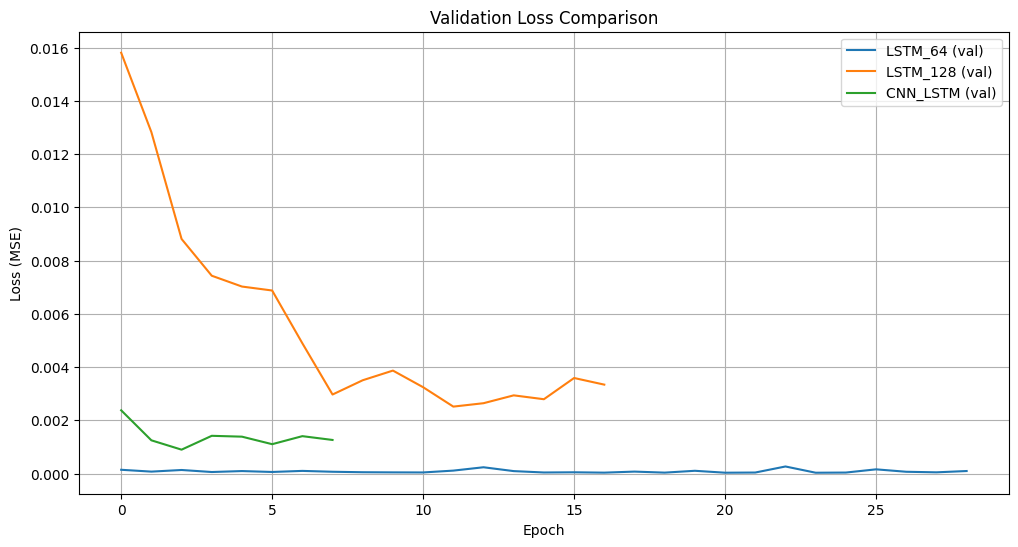

In [ ]:
plt.figure(figsize=(12,6))
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{name} (val)')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


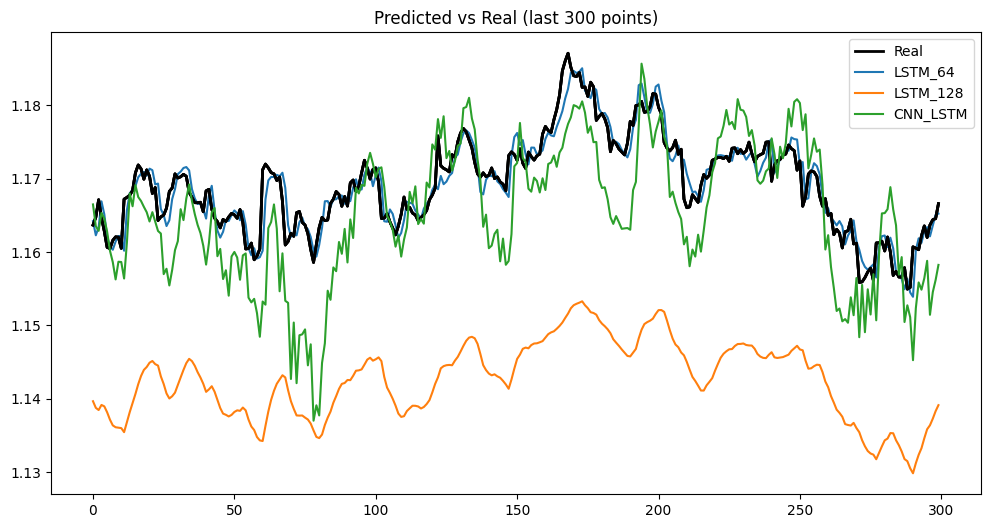

In [ ]:
plt.figure(figsize=(12,6))

# หาคอลัมน์ target จริงจาก scaler (เพื่อใช้ index ที่ถูก)
feature_cols = list(scaler.feature_names_in_) if hasattr(scaler, 'feature_names_in_') else ['open','high','low','close','volume']
close_idx = feature_cols.index('close')

for name, model in models.items():
    pred = model.predict(X_test)

    # dummy array ที่มี feature ครบเท่าตอน fit scaler
    dummy_pred = np.zeros((len(pred), len(feature_cols)))
    dummy_pred[:, close_idx] = pred[:, 0]
    pred_prices = scaler.inverse_transform(dummy_pred)[:, close_idx]

    dummy_real = np.zeros((len(y_test), len(feature_cols)))
    dummy_real[:, close_idx] = y_test
    real_prices = scaler.inverse_transform(dummy_real)[:, close_idx]

    plt.plot(real_prices[-300:], label='Real' if name=='LSTM_64' else None, color='black', linewidth=2)
    plt.plot(pred_prices[-300:], label=name)

plt.title('Predicted vs Real (last 300 points)')
plt.legend()
plt.show()